In this notebook, I want to use a slightly different Earth model: I want to use the grid with 85 km spacing (150 1D grid size) for most of the Earth, but a grid of 1 km spacing for everything within 85 km of SNO+. The issue is that when we do this it's hard to figure out what the overlap is. 

Alternative (I'm actually going to try this) : Make a grid with spacing of 5 km, but only keep points within 100 km of SNO+. Given that everything is scaled by the inverse of the distance squared, I think that the overwhelming makority of neutrinos will be coming from this bit.



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from joblib import Parallel, delayed

I think generating points for the whole Earth will be a waste of time and memory, so only generate points such that: $x \in [-100, 100]$, $y \in [-100, 100]$, $z \in [R_{Earth} - 102 , R_{Earth}]$ where $R_{Earth} = 6371$

In [19]:
# make earth grid
# use high grid count, but will get rid of most of it

R_Earth = 6371.000

xsize = 101
ysize = 101
zsize = 52

x_range = np.linspace( -100, 100, xsize)
y_range = np.linspace(-100, 100, ysize)
z_range = np.linspace(R_Earth-102, R_Earth, zsize)

x_grid, y_grid, z_grid = np.meshgrid(x_range, y_range, z_range)

earth_grid = np.zeros((xsize*ysize*zsize, 3))
index = 0

for i in range(xsize):
    for j in range(ysize):
        for k in range(zsize):
            if x_grid[i, j, k]**2 + y_grid[i, j, k]**2 + z_grid[i, j, k]**2 <= 6371**2:
                earth_grid[index] = np.array([x_grid[i, j, k], y_grid[i, j, k], z_grid[i, j, k]])
                index += 1

earth_grid = earth_grid[:index]

In [20]:
print(len(earth_grid))
print(250**3)
print(x_range[1]-x_range[0])
print(y_range[1]-y_range[0])
print(z_range[1]-z_range[0])

520252
15625000
2.0
2.0
2.0


This should be much much faster. For now, we settled on a grid with points at 2km from each other, but I think we can easily increase to 0.5 km, or even 0.25. We shall see.

In [21]:
#set abundances and densities; weight average density by shell volume

rho_core = 0
A_Th_core = 0
A_U_core = 0

rho_mantle = 4.5 #g/cm^3 -- I just looked this up
#I'm not sure what the units are supposed to be but this will just be a scaling factor, we mostly care about the shape of 
#the spectrum, not the absolute value 

A_Th_c = 5 * (10**(-6))
A_Th_m = 8 * (10**(-8))
A_U_c = 1 * (10**(-6))
A_U_m = 2 * (10**(-8))

r_outer_crust = 6371
r_inner_crust = 6371 - 20
r_outer_mantle = r_inner_crust
r_inner_mantle = r_outer_mantle - 2900

def shell_volume(r_inner, r_outer):
    return (4/3)*math.pi*(r_outer**2 + r_outer*r_inner + r_inner**2)*(r_outer - r_inner)

crust_volume = shell_volume(r_inner_crust, r_outer_crust)
mantle_volume = shell_volume(r_inner_mantle, r_outer_mantle)

print("Crust volume is "+str(crust_volume))
print("Mantle volume is "+str(mantle_volume))

A_Th_mantle = (A_Th_m*mantle_volume + A_Th_c*crust_volume)/(crust_volume + mantle_volume)
A_U_mantle = (A_U_m*mantle_volume + A_U_c*crust_volume)/(crust_volume + mantle_volume)

Crust volume is 10169298809.643768
Mantle volume is 900881093278.6835


In [22]:
#set position of SNO+

SNO_r = np.array([0, 0, 6369])

In [23]:
# function to calculate relative distance to SNO+ from points in earth grid

def calc_relative_dist(points_array):
    relative_distances = np.zeros(len(points_array))
    for i in range(len(points_array)):
        # Index each point individually
        point = points_array[i]
        relative_distances[i] = np.sqrt((point[0] - SNO_r[0])**2 + (point[1] - SNO_r[1])**2 + (point[2] - SNO_r[2])**2)

    return relative_distances
#distances calculated in km

In the other notebook (FULL etc etc), the next step is to make arrays with the abundances and density, but we'll skip this for now because we just want to compute this as quickly as possible. If we had a more detailed Earth model, that would indeed be very helpful, but for now we don't need it.

In [24]:
#define Delta function for an array of points and energies
#inputs: appropriate deltam _ij^2, energy array [MeV], points array
#relative distance calculated in km, hence Delta scaled up by a factor of 1000 to account for m-km conversion

def Delta_ij(energy_array, points_array, delta_m_ij_squared):
    
    Delta = np.zeros((len(energy_array), len(points_array)))
    #want positions relative to sno+
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            Delta[i][j] = (1.27 * delta_m_ij_squared * relative_distance_array[j] * 1000) / (energy_array[i])
            
    return Delta

Will use the full survival probability, so only define and use that

In [25]:
#define FULL survival probability formula for arrays of points and energies

def P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    #want positions relative to sno+
    relative_distance_array = calc_relative_dist(points_array)
    
    Delta_31 = Delta_ij(energy_array, points_array, delta_m_31_squared)
    #Delta_32 = Delta_ij(energy_array, points_array, delta_m_32_squared)
    #the two things above are equal but keep separate for clarity/flexibility
    #uncomment line if you need
    Delta_32 = Delta_31
    Delta_12 = Delta_ij(energy_array, points_array, delta_m_21_squared)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - ( (np.cos(theta_13))**4 * (np.sin(2 * theta_12))**2 * (np.sin(Delta_12[i][j]))**2 + (np.cos(2*theta_12) **2 * np.sin(Delta_31[i][j])**2  + np.sin(2*theta_12) **2 * np.sin(Delta_32[i][j])**2)* (np.sin(2 * theta_13))**2)

    #because the two deltas with 3 are equal here, all this does is replace
    #the factor of 1/2 in front of sin^2(2theta_13) with a factor of
    #sin^2(delta_31)

    
    
    return P_ee


In [26]:
#set standard oscillation parameters

theta_12 = 0.5903 #rad
theta_23 = 0.8430 #rad
theta_13 = 0.1503 #rad

delta_m_21_squared = 7.39 * 10**(-5) #eV^2
delta_m_32_squared = 2.449 * 10**(-3) #eV^2
delta_m_31_squared = delta_m_32_squared

In [27]:
energy_array = np.linspace(1.8, 3.3, 100)

Now we have more points in the Earth points array than we want, because we haven't yet imposed the condition that the distance between the point and SNO+ has to be smaller than 100 km

In [28]:
earth_grid_distances = calc_relative_dist(earth_grid)
mask = earth_grid_distances <= 100
new_earth_grid = np.array(earth_grid)[mask]

In [29]:
print(len(new_earth_grid))

265576


Define Uranium and Thorium integrals differently, so that the density and abundance are just numbers not arrays. Can find more general definitions in FULL notebook. Also use numpy operations in the way chatgpt suggested

In [30]:
grid_1d_size = x_range[1] - x_range[0]

In [31]:
#integral naming schemes

#Th_integral_values for approximate formula, standard oscillation parameters
#Th_integral_values_low_theta for some lower theta, approximate formula; same for mid and high
#Th_integral_values_constant_P_ee for integrating using constant survival probability

In [32]:
print(grid_1d_size)

2.0


In [41]:
'''def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    sum_Th = np.zeros(len(energy_array))
    sum_U = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_Th[j] += P_ee_array[j][i] * ((A_Th * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            #print("computed for energy "+str(j)+" out of "+str(len(energy_array)))
       
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            if relative_distance_array[i] == 0:
                print('Skipping point overlapping with SNO+')
            else:
                sum_U[j] += P_ee_array[j][i] * ((A_U * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
          

    return sum_Th, sum_U'''

#the thing commented above was the previous version of this; optimized version (3:52 vs 3:20 sec with 100 dist 2 spacing)
'''
from joblib import Parallel, delayed
'''

def integral_over_positions_Th_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th, A_U, rho):
    dV = grid_1d_size**3

    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee_full(energy_array, points_array, theta_12, theta_13, delta_m_21_squared)

    def compute_sum(A, energy):
        sum_array = np.zeros(len(points_array))
        for i in range(len(points_array)):
            if relative_distance_array[i] != 0:
                sum_array[i] = P_ee_array[energy][i] * ((A * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        return np.sum(sum_array)

    sum_Th = np.array(Parallel(n_jobs=-1)(delayed(compute_sum)(A_Th, j) for j in range(len(energy_array))))
    sum_U = np.array(Parallel(n_jobs=-1)(delayed(compute_sum)(A_U, j) for j in range(len(energy_array))))

    return sum_Th, sum_U

Now that everything we had to redefine is redefined, compute the same plots as before

In [42]:
Th_integral_values, U_integral_values = integral_over_positions_Th_U(new_earth_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_mantle, A_U_mantle, rho_mantle)

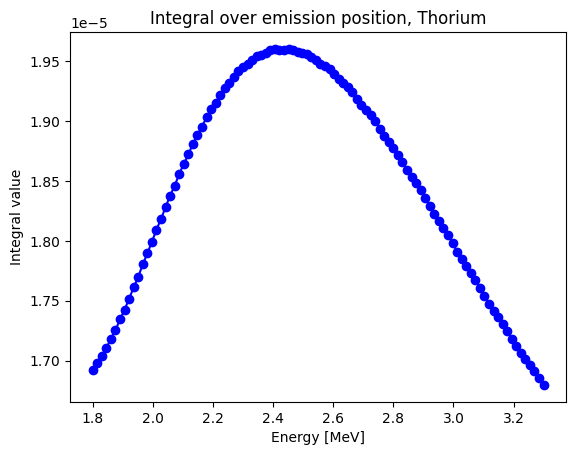

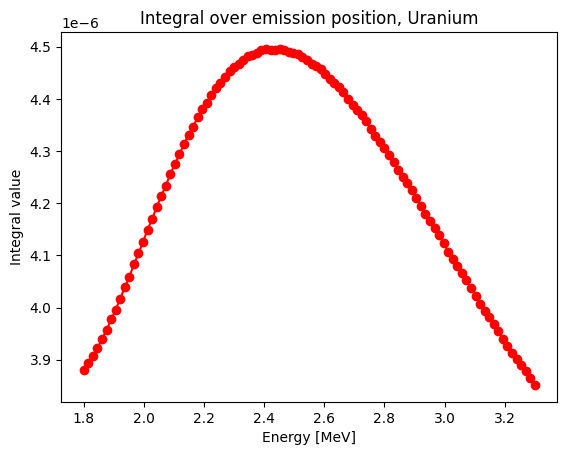

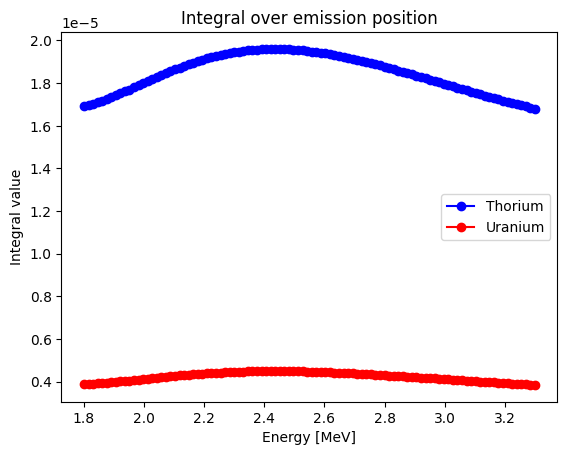

In [135]:
#make plots

#Thorium
plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
#plt.savefig('Integral over emission position, Thorium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
#plt.savefig('Integral over emission position, Uranium, standard oscillation parameters.pdf', format='pdf')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
#plt.savefig('Integral over emission position, standard oscillation parameters.pdf', format='pdf')
plt.show()



In [ ]:
'''previous def:
   def compute_sum(A, energy):
        sum_array = np.zeros(len(points_array))
        for i in range(len(points_array)):
            if relative_distance_array[i] != 0:
                sum_array[i] = P_ee_array[energy][i] * ((A * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        return np.sum(sum_array)'''

In [136]:
def integral_over_positions_Th_U_constant_P_ee(points_array, energy_array, A_Th, A_U, rho):

    sum_Th = np.zeros(len(energy_array))
    sum_U = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    
    #value from Ingrida's thesis, probably the same as in rat\n",
    P_ee = 0.553
    #we lose the energy dependence in the integral because it only shows up in P_ee, which is now taken to be constant
    #so now instead of a range of values, there is just one value; keep it as an array to make it easier to make plots
    #but all the elements in the array will be the same
    
    sum_value_Th = 0
    sum_value_U = 0

    for i in range(len(points_array)):
        if relative_distance_array[i] == 0:
            print('Skipping point overlapping with SNO+')
        else:
            sum_value_Th += P_ee * ((A_Th * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        for j in range(len(sum_Th)):
            sum_Th[j] = sum_value_Th
    for i in range(len(points_array)):
        if relative_distance_array[i] == 0:
            print('Skipping point overlapping with SNO+')
        else:
            sum_value_U += P_ee * ((A_U * rho) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
        for j in range(len(sum_U)):
            sum_U[j] = sum_value_U

    return sum_Th, sum_U

In [137]:
Th_integral_values_constant_P_ee, U_integral_values_constant_P_ee= integral_over_positions_Th_U_constant_P_ee(new_earth_grid, energy_array, A_Th_mantle, A_U_mantle, rho_mantle)

Skipping point overlapping with SNO+
Skipping point overlapping with SNO+


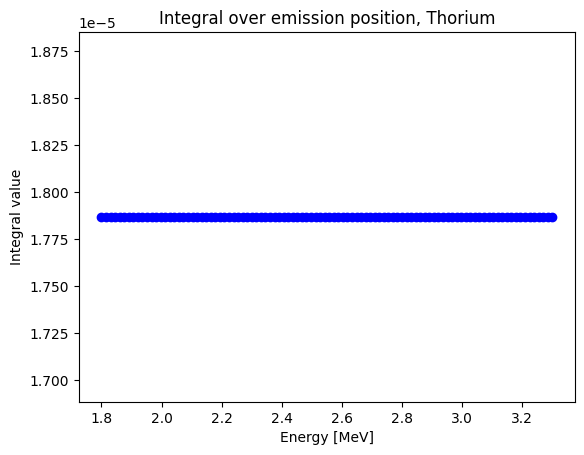

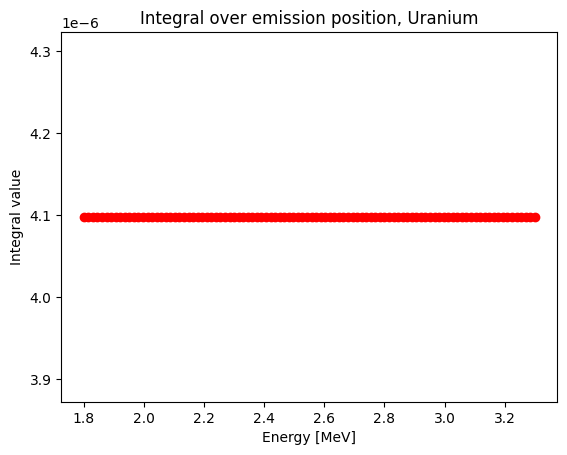

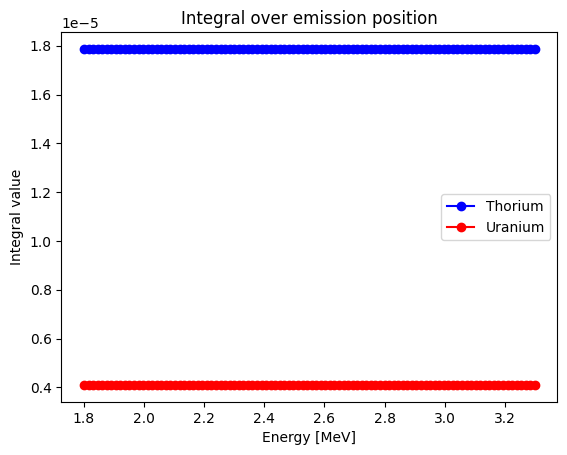

In [138]:
#make plots, just for integrals with constant P_ee

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.show()

#Both together

plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b', label='Thorium')
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r', label='Uranium')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')
plt.legend()
plt.show()

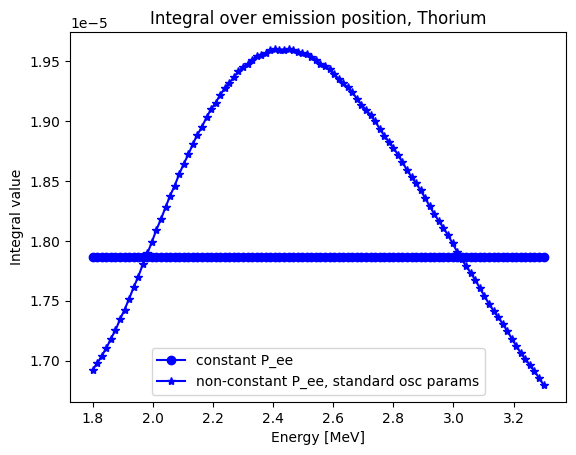

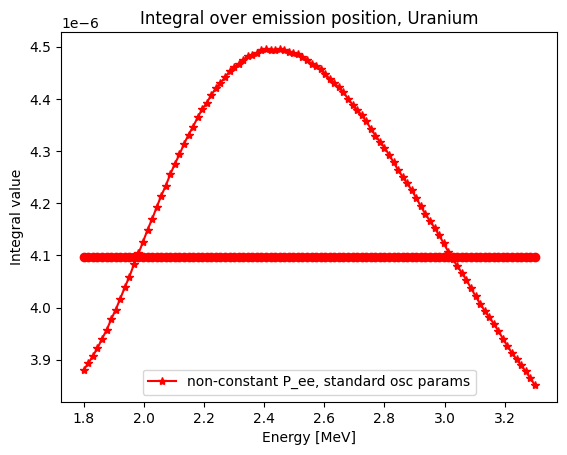

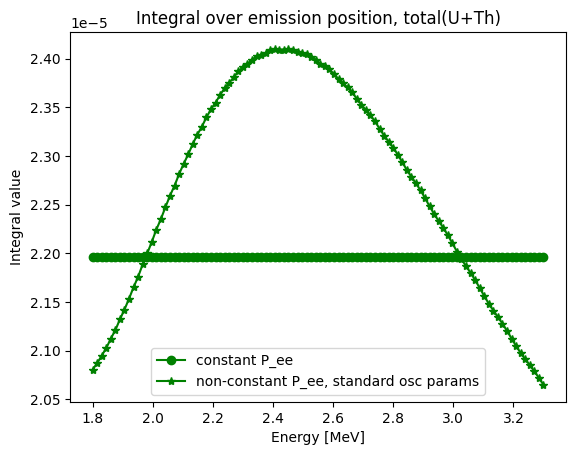

In [139]:
#make plots to compare integral for constant P_ee and non-constant(dependent on energy and oscillation parameters)

#Thorium
plt.plot(energy_array, Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='b', label='constant P_ee')
plt.plot(energy_array, Th_integral_values, marker='*', linestyle='-', color='b', label='non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')
plt.legend()
plt.savefig('Thorium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_constant_P_ee, marker='o', linestyle='-', color='r')
plt.plot(energy_array, U_integral_values, marker='*', linestyle='-', color='r', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')
plt.legend()
plt.savefig('Uranium Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.show()

#Total

plt.plot(energy_array, U_integral_values_constant_P_ee + Th_integral_values_constant_P_ee, marker='o', linestyle='-', color='g', label = 'constant P_ee')
plt.plot(energy_array, np.array(U_integral_values) + np.array(Th_integral_values), marker='*', linestyle='-', color='g', label = 'non-constant P_ee, standard osc params')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th)')
plt.savefig('Total Integral, standard osc params vs constant P_ee.pdf', format='pdf')
plt.legend()
plt.show()

In [140]:
print(len(U_integral_values_constant_P_ee + Th_integral_values_constant_P_ee))
print(len(energy_array))
print(len(U_integral_values + Th_integral_values))
print(len(U_integral_values))

100
100
100
100


In [141]:
#change to survival probability from Shuai

def sigma_IBD(energy_array):
    
    m_e = 0.511 #MeV
    m_p = 938 #MeV
    m_n = 941 #MeV
    E_th = 1.8 #MeV
    
    sigma = np.zeros(len(energy_array))
    
    for i in range(len(energy_array)):
        sigma [i] = ((energy_array[i] - E_th + m_e)**2) * ((1 - (m_e)**2/((energy_array[i] - E_th + m_e)**2))**(1/2))
    
    return sigma

In [142]:
#all these + sources in Earth model more bins -3 (for example)

lambda_U = 4.916
lambda_Th = 1.563
mu_U = 235
mu_Th = 232

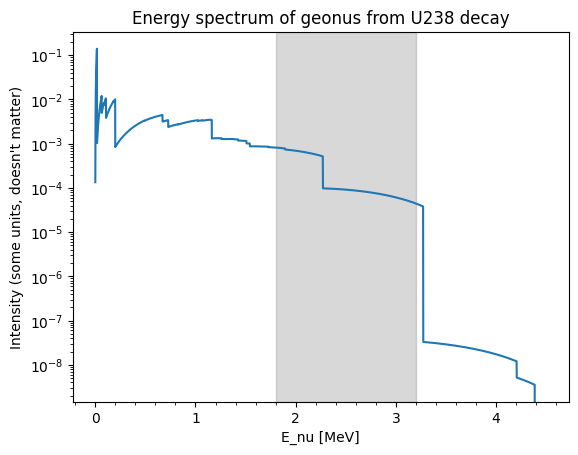

In [143]:
#get fluxes
energy_array_U = []
dn_dE_U = []

with open('U238_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_U.append(float(columns[0]))
        dn_dE_U.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_U = np.array(energy_array_U) / 1000
dn_dE_U = np.array(dn_dE_U)

plt.plot(energy_array_U, dn_dE_U)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from U238 decay')

# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# Enable minor ticks on x-axis
plt.minorticks_on()
plt.show()


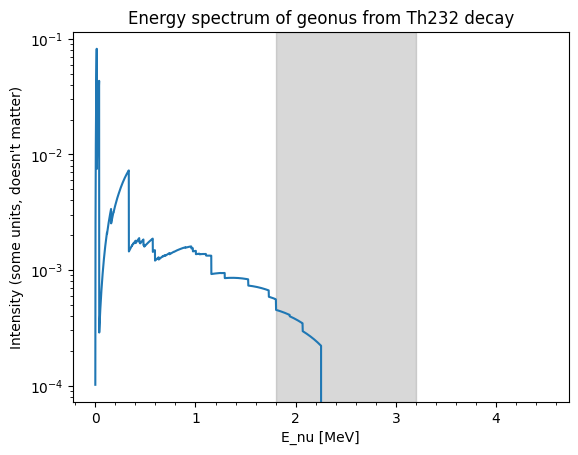

In [144]:
energy_array_Th = []
dn_dE_Th = []
with open('Th232_spectrum.txt', 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.split()

        # Convert the elements to float and append to arrays
        energy_array_Th.append(float(columns[0]))
        dn_dE_Th.append(float(columns[1]))

# Scale down all energies by a factor of 1000
energy_array_Th = np.array(energy_array_Th) / 1000
dn_dE_Th = np.array(dn_dE_Th)

plt.plot(energy_array_Th, dn_dE_Th)
plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus from Th232 decay')
# Add shaded region between 1.8 MeV and 3.2 MeV
plt.axvspan(1.8, 3.2, alpha=0.3, color='gray')
# Enable minor ticks on x-axis
plt.minorticks_on()
plt.show()

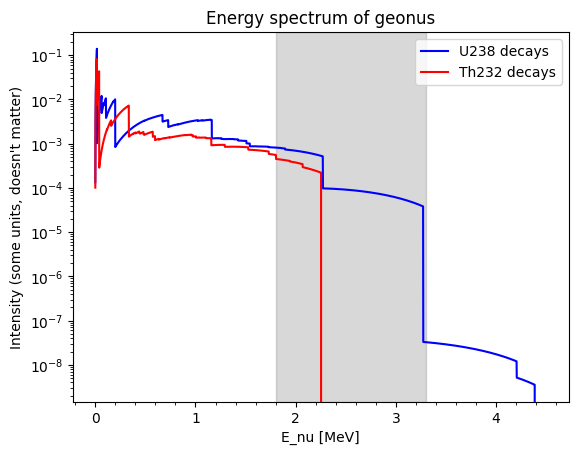

In [145]:
# Plot U238 decay data (blue line)
plt.plot(energy_array_U, dn_dE_U, label='U238 decays', color='blue')

# Plot Th232 decay data (red line)
plt.plot(energy_array_Th, dn_dE_Th, label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Add shaded region between 1.8 MeV and 3.3 MeV
plt.axvspan(1.8, 3.3, alpha=0.3, color='gray')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

In [146]:
def rebin_counts(initial_bins, counts_in_initial_bins, final_bin_midpoints):
    """
    Rebins counts data.

    Parameters:
    - initial_bins: array, bin edges of the initial data
    - counts_in_initial_bins: array, counts in each initial bin
    - final_bin_midpoints: array, midpoints of the final desired bins

    Returns:
    - counts_in_final_bins: array, counts in each final bin
    """

    # Calculate bin midpoints of the initial bins
    bin_midpoints = (initial_bins[:-1] + initial_bins[1:]) / 2

    # Use np.histogram to calculate counts in final bins
    counts_in_final_bins, _ = np.histogram(initial_bins, bins=np.concatenate([initial_bins, [2 * initial_bins[-1] - initial_bins[-2]]]), weights=counts_in_initial_bins)

    # Interpolate the counts to the final bin midpoints
    counts_in_final_bins = np.interp(final_bin_midpoints, bin_midpoints, counts_in_final_bins[:-1])

    return counts_in_final_bins

In [147]:
dn_dE_rebinned_U = rebin_counts(energy_array_U, dn_dE_U, energy_array)
dn_dE_rebinned_Th = rebin_counts(energy_array_Th, dn_dE_Th, energy_array)

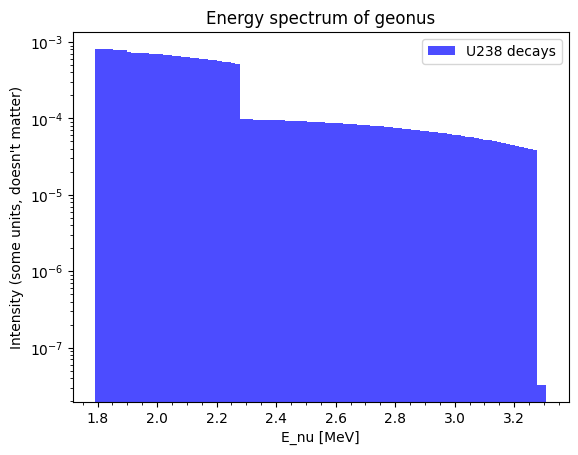

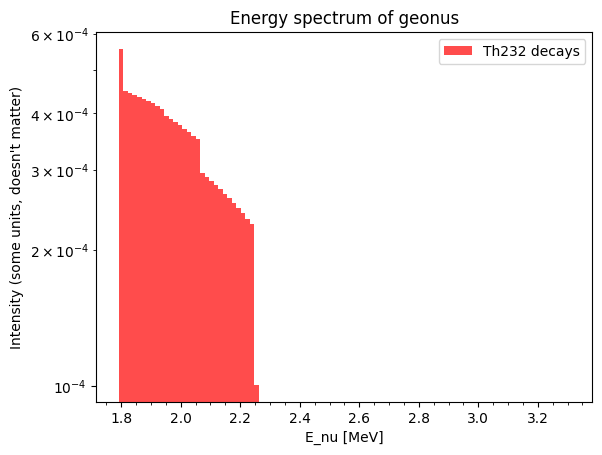

In [148]:
bin_width = energy_array[1] - energy_array[0]

# Plot histogram U
plt.bar(energy_array, dn_dE_rebinned_U, width=bin_width, label='U238 decays', color='blue', alpha=0.7)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

# Plot histogram Th
plt.bar(energy_array, dn_dE_rebinned_Th, width=bin_width, label='Th232 decays', color='red', alpha=0.7)

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

plt.legend(loc='upper right')

plt.show()

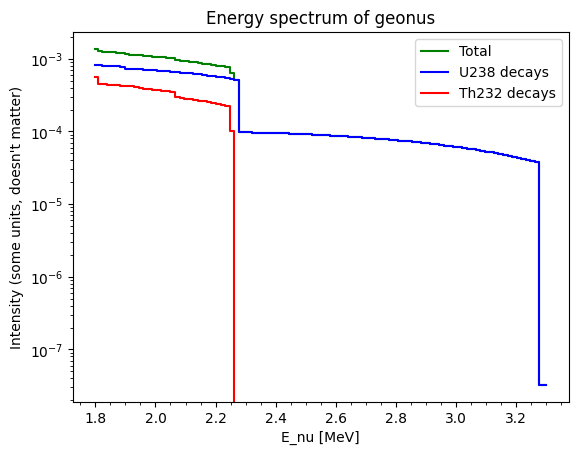

In [149]:
# Plot histogram for both
plt.step(energy_array, dn_dE_rebinned_U + dn_dE_rebinned_Th, where='mid', label='Total', color='green')
plt.step(energy_array, dn_dE_rebinned_U, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, dn_dE_rebinned_Th, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Intensity (some units, doesn\'t matter)')
plt.title('Energy spectrum of geonus')

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [150]:
sigma = sigma_IBD(energy_array)


In [151]:
N_Th = np.zeros(len(energy_array))
N_U = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values[i]
    N_U[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values[i]
    

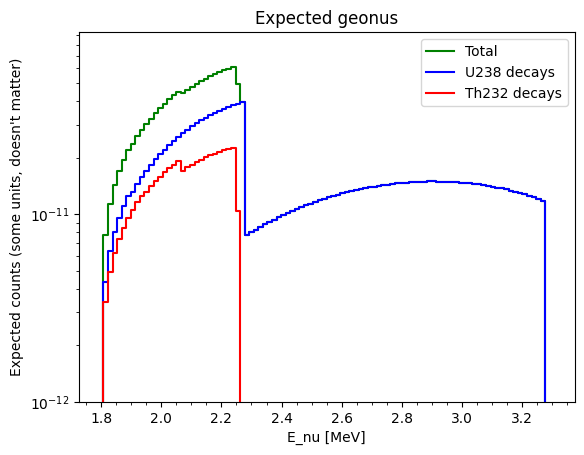

In [152]:
# Plot histogram for both
plt.step(energy_array, N_U + N_Th, where='mid', label='Total', color='green')
plt.step(energy_array, N_U, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()


In [153]:
N_Th_constant_P_ee = np.zeros(len(energy_array))
N_U_constant_P_ee = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_constant_P_ee[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_constant_P_ee[i]
    N_U_constant_P_ee[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_constant_P_ee[i]
    

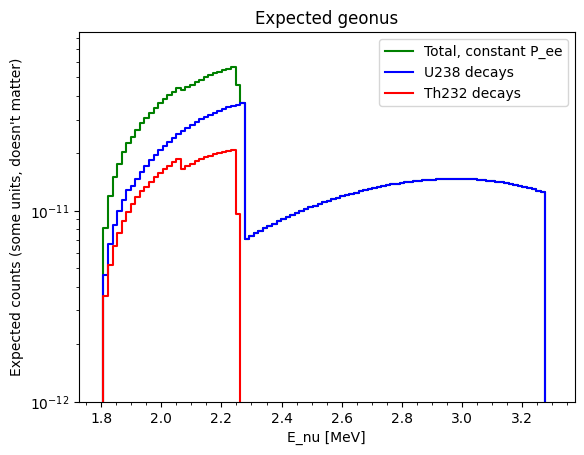

In [154]:
# Plot histogram for both, constant P_ee only
plt.step(energy_array, N_U_constant_P_ee + N_Th_constant_P_ee, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U_constant_P_ee, where='mid', label='U238 decays', color='blue')
plt.step(energy_array, N_Th_constant_P_ee, where='mid', label='Th232 decays', color='red')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

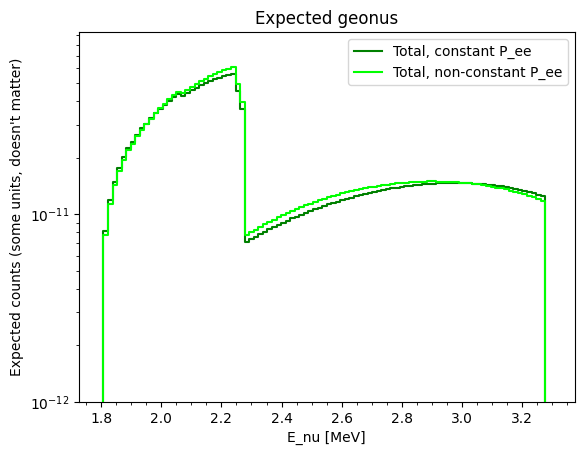

/tmp/ipykernel_26256/268974271.py:24: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_constant_P_ee + N_Th_constant_P_ee) / (N_U + N_Th), label='ratio', color='green')


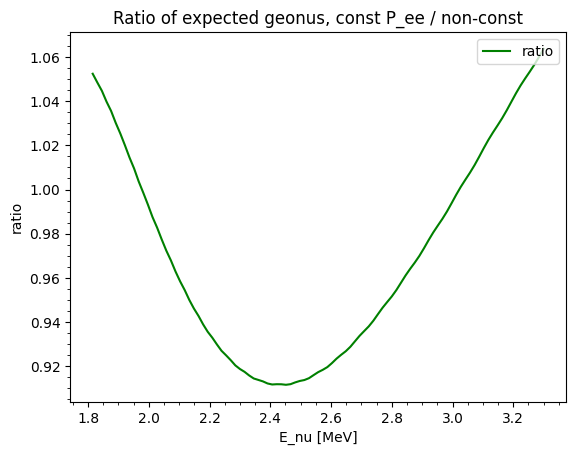

In [155]:
#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_constant_P_ee + N_Th_constant_P_ee, where='mid', label='Total, constant P_ee', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='Total, non-constant P_ee', color='lime')

plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Expected counts, standard params vs constant P_ee.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_constant_P_ee + N_Th_constant_P_ee) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, const P_ee / non-const')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Ratio of expected geonus, standard params vs constant P_ee.pdf', format='pdf')

plt.show()

In [156]:
theta_12_low = 0.2 #rad
theta_12_high = 1

delta_m_21_squared_low = 5 * 10**(-5) #eV^2
delta_m_21_squared_high = 1.2 * 10**(-4)

In [157]:
Th_integral_values_theta_low, U_integral_values_theta_low = integral_over_positions_Th_U(new_earth_grid, energy_array, grid_1d_size, theta_12_low, delta_m_21_squared, A_Th_mantle, A_U_mantle, rho_mantle)

In [158]:
Th_integral_values_theta_high, U_integral_values_theta_high = integral_over_positions_Th_U(new_earth_grid, energy_array, grid_1d_size, theta_12_high, delta_m_21_squared, A_Th_mantle, A_U_mantle, rho_mantle)

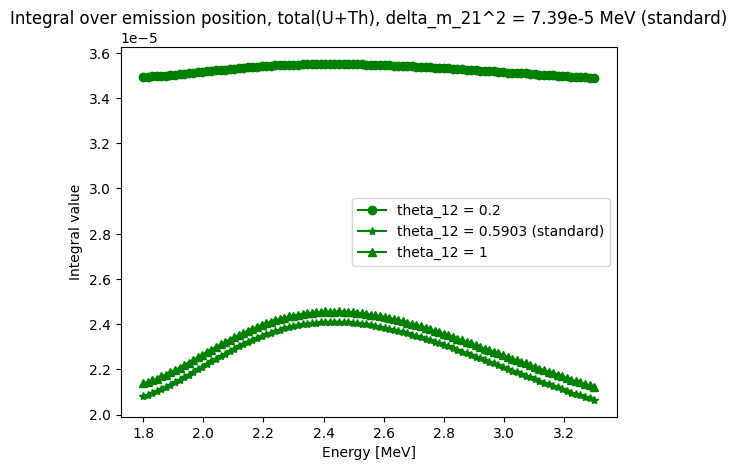

In [159]:
#make plots of integral to compare

#Total

plt.plot(energy_array, U_integral_values_theta_low + Th_integral_values_theta_low, marker='o', linestyle='-', color='g', label = 'theta_12 = 0.2')
plt.plot(energy_array, U_integral_values + Th_integral_values, marker='*', linestyle='-', color='g', label = 'theta_12 = 0.5903 (standard)')
plt.plot(energy_array, U_integral_values_theta_high + Th_integral_values_theta_high, marker='^', linestyle='-', color='g', label = 'theta_12 = 1')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th), delta_m_21^2 = 7.39e-5 MeV (standard)')
plt.legend()
plt.savefig('Total Integral, standard delta m.pdf', format='pdf')
plt.show()

In [160]:
#calculate total expected fluxes

N_Th_theta_low = np.zeros(len(energy_array))
N_U_theta_low = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_theta_low[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_theta_low[i]
    N_U_theta_low[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_theta_low[i]
    

In [161]:

N_Th_theta_high = np.zeros(len(energy_array))
N_U_theta_high = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_theta_high[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_theta_high[i]
    N_U_theta_high[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_theta_high[i]
   

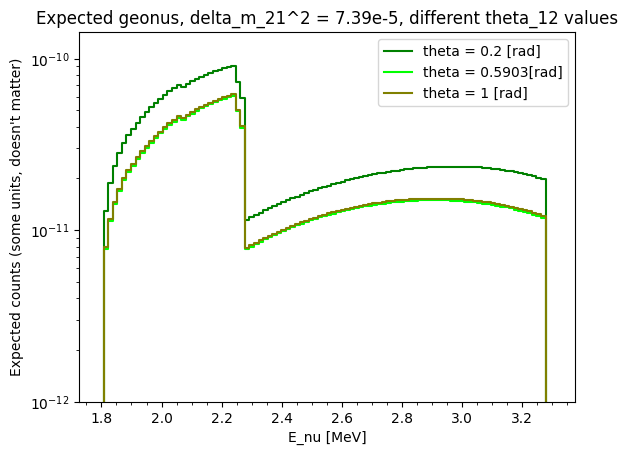

/tmp/ipykernel_26256/3068826981.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_theta_low + N_Th_theta_low) / (N_U + N_Th), label='ratio', color='green')


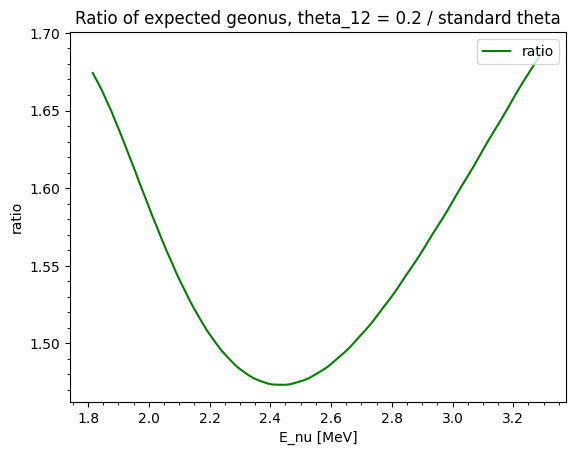

/tmp/ipykernel_26256/3068826981.py:45: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_theta_high + N_Th_theta_high) / (N_U + N_Th), label='ratio', color='olive')


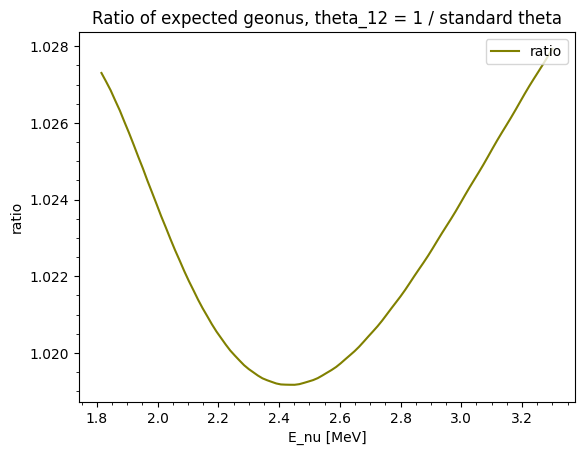

In [162]:
#plot comparisons

#plot to compare total for constant P_ee vs non-constant P_ee with standard osc parameters

plt.step(energy_array, N_U_theta_low + N_Th_theta_low, where='mid', label='theta = 0.2 [rad]', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='theta = 0.5903[rad]', color='lime')
plt.step(energy_array, N_U_theta_high + N_Th_theta_high, where='mid', label='theta = 1 [rad]', color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, delta_m_21^2 = 7.39e-5, different theta_12 values')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Expected geonu, standard delta m.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_theta_low + N_Th_theta_low) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, theta_12 = 0.2 / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Ratio of expected geonu, standard delta m, low theta.pdf', format='pdf')

plt.show()

plt.plot(energy_array, (N_U_theta_high + N_Th_theta_high) / (N_U + N_Th), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, theta_12 = 1 / standard theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Ratio of expected geonu, standard delta m, high theta.pdf', format='pdf')

plt.show()

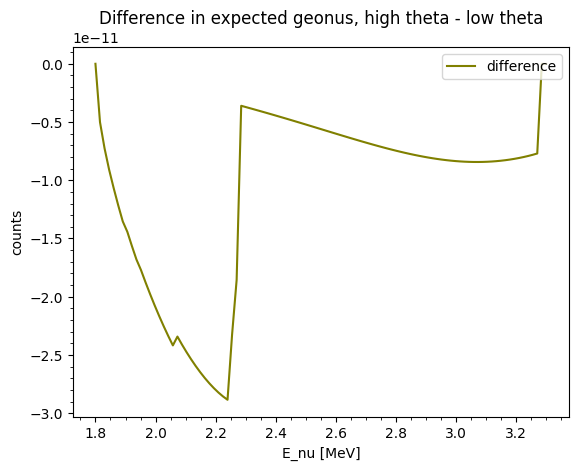

In [163]:
plt.plot(energy_array, N_U_theta_high + N_Th_theta_high - N_U_theta_low - N_Th_theta_low, label='difference', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('counts')
plt.title('Difference in expected geonus, high theta - low theta')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')

plt.show()

In [164]:
Th_integral_values_delta_m_low, U_integral_values_delta_m_low = integral_over_positions_Th_U(new_earth_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_low, A_Th_mantle, A_U_mantle, rho_mantle)

In [165]:
Th_integral_values_delta_m_high, U_integral_values_delta_m_high = integral_over_positions_Th_U(new_earth_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared_high, A_Th_mantle, A_U_mantle, rho_mantle)

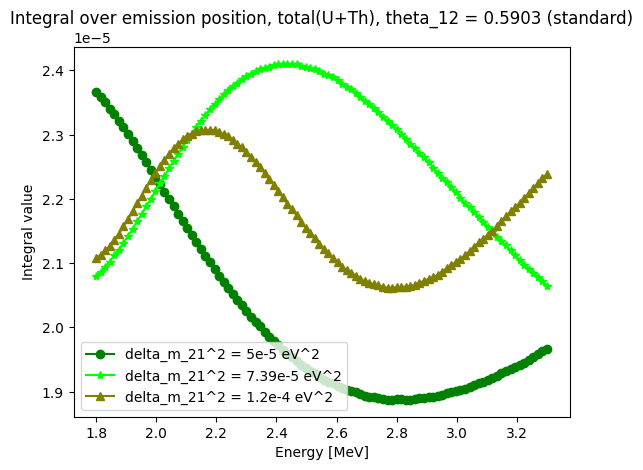

In [166]:
#make plots of integral to compare

#Total

plt.plot(energy_array, U_integral_values_delta_m_low + Th_integral_values_delta_m_low, marker='o', linestyle='-', color='g', label = 'delta_m_21^2 = 5e-5 eV^2')
plt.plot(energy_array, U_integral_values + Th_integral_values, marker='*', linestyle='-', color='lime', label = 'delta_m_21^2 = 7.39e-5 eV^2')
plt.plot(energy_array, U_integral_values_delta_m_high + Th_integral_values_delta_m_high, marker='^', linestyle='-', color='olive', label = 'delta_m_21^2 = 1.2e-4 eV^2')
plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, total(U+Th), theta_12 = 0.5903 (standard)')
plt.legend()
plt.savefig('Total integral, standard theta.pdf', format = 'pdf')
plt.show()

In [167]:
#calculate total expected fluxes

N_Th_delta_m_low = np.zeros(len(energy_array))
N_U_delta_m_low = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_delta_m_low[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_delta_m_low[i]
    N_U_delta_m_low[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_delta_m_low[i]
    

In [168]:
N_Th_delta_m_high = np.zeros(len(energy_array))
N_U_delta_m_high = np.zeros(len(energy_array))

for i in range(len(energy_array)):
    N_Th_delta_m_high[i] = ((lambda_Th)/(mu_Th)) * sigma[i] * dn_dE_rebinned_Th[i] * Th_integral_values_delta_m_high[i]
    N_U_delta_m_high[i] = ((lambda_U)/(mu_U)) * sigma[i] * dn_dE_rebinned_U[i] * U_integral_values_delta_m_high[i]
   

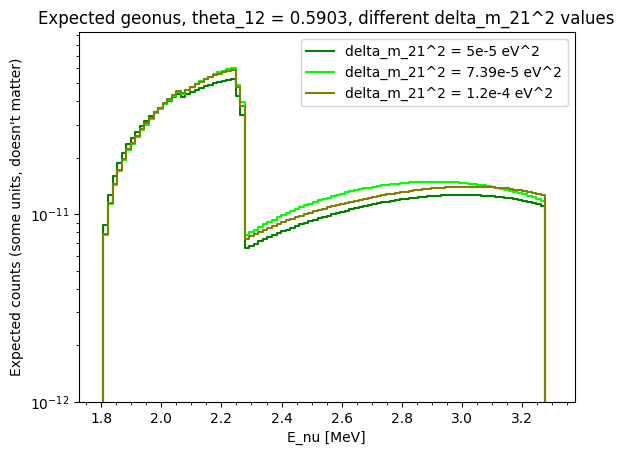

/tmp/ipykernel_26256/2913704676.py:25: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_delta_m_low + N_Th_delta_m_low) / (N_U + N_Th), label='ratio', color='green')


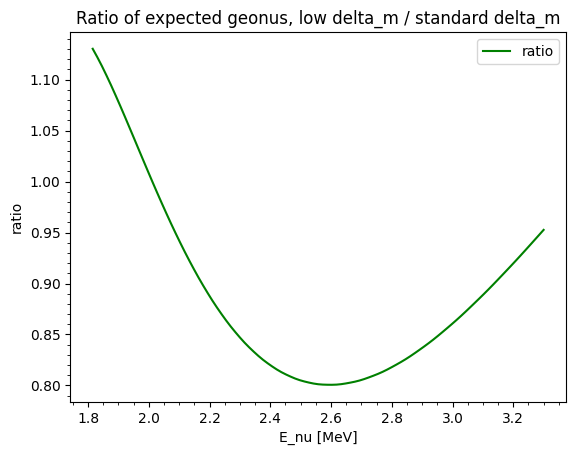

/tmp/ipykernel_26256/2913704676.py:41: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(energy_array, (N_U_delta_m_high + N_Th_delta_m_high) / (N_U + N_Th), label='ratio', color='olive')


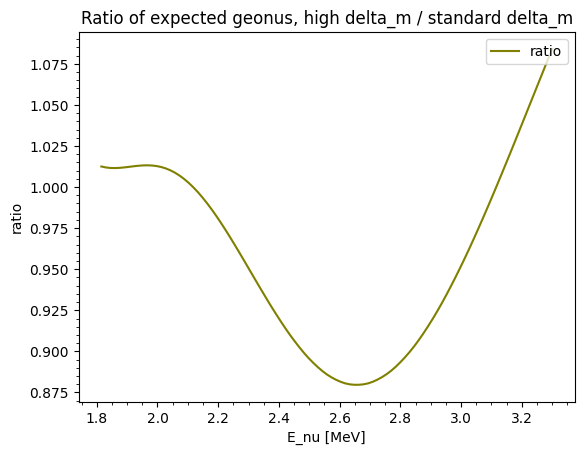

In [169]:
#plot comparisons
plt.step(energy_array, N_U_delta_m_low + N_Th_delta_m_low, where='mid', label='delta_m_21^2 = 5e-5 eV^2', color='green')
plt.step(energy_array, N_U + N_Th, where='mid', label='delta_m_21^2 = 7.39e-5 eV^2', color='lime')
plt.step(energy_array, N_U_delta_m_high + N_Th_delta_m_high, where='mid', label='delta_m_21^2 = 1.2e-4 eV^2', color='olive')


plt.xlabel('E_nu [MeV]')
plt.yscale('log')
plt.ylabel('Expected counts (some units, doesn\'t matter)')
plt.title('Expected geonus, theta_12 = 0.5903, different delta_m_21^2 values')

# Set lower limit for y-axis to 10^-7
plt.ylim(bottom=1e-12)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Expected geonu, standard theta.pdf', format='pdf')

plt.show()


plt.plot(energy_array, (N_U_delta_m_low + N_Th_delta_m_low) / (N_U + N_Th), label='ratio', color='green')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, low delta_m / standard delta_m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Ratio of expected geonu, standard theta, low delta m.pdf', format='pdf')
plt.show()

plt.plot(energy_array, (N_U_delta_m_high + N_Th_delta_m_high) / (N_U + N_Th), label='ratio', color='olive')
plt.xlabel('E_nu [MeV]')
plt.ylabel('ratio')
plt.title('Ratio of expected geonus, high delta_m / standard delta_m')

# Set lower limit for y-axis to 10^-7
#plt.ylim(bottom=1e-7)

# Enable minor ticks on x-axis
plt.minorticks_on()

# Add legend
plt.legend(loc='upper right')
plt.savefig('Ratio of expected geonu, standard theta, high delta m.pdf', format='pdf')
plt.show()